<a href="https://colab.research.google.com/github/taresadere/taresadere/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras

In [ ]:
!pip install keras.applications.resnet50

ERROR: Could not find a version that satisfies the requirement keras.applications.resnet50 (from versions: none)
ERROR: No matching distribution found for keras.applications.resnet50


In [14]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19

In [ ]:
img_width, img_height = 224, 224

In [16]:
# Declaration
from keras import backend
train_path = "drive/My Drive/train"
valid_path ="drive/My Drive/validation"
test_path = "drive/My Drive/test"
IMAGE_SIZE=(224, 224)
from keras.preprocessing import image
classes= ["normal", "follicular", "intense", "scar", "trichiasis", "corneal opacity"]
def model_predict(img_path, model):
    image = cv2.imread(img_path)
    #image = cv2.resize(image, (224, 224))
    image = cv2.resize(image,   IMAGE_SIZE)
    image = image.astype("float") / 255.0
    #image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    res = model.predict(image)
    label = np.argmax(res)
    print("Label", label)
    labelName = classes[label]
    print("Label name:", labelName)
    return labelName
batch_size = 32
EPOCHS = 10
RANDOM_SEED = 42

if backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMAGE_SIZE[0], IMAGE_SIZE[1],1)
else:
    INPUT_SHAPE = (1,IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

print(f'input_shape: {INPUT_SHAPE}')


input_shape: (1, 224, 224, 3)


In [17]:
# Prepare train/test using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = tuple(IMAGE_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

valid_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = tuple(IMAGE_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 179 images belonging to 6 classes.
Found 76 images belonging to 6 classes.


In [27]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(6, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False


In [28]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
import tensorflow as tf
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [30]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]
# Fine-tune
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
# fit the model, it will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)
print('Training time: %s' % (now() - t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
6/6 [==============================] - 43s 8s/step - loss: 2.2333 - accuracy: 0.2179 - val_loss: 1.9654 - val_accuracy: 0.1711
Epoch 2/10
6/6 [==============================] - 4s 693ms/step - loss: 2.0894 - accuracy: 0.2235 - val_loss: 1.9588 - val_accuracy: 0.2105
Epoch 3/10
6/6 [==============================] - 4s 699ms/step - loss: 1.9649 - accuracy: 0.2402 - val_loss: 1.7862 - val_accuracy: 0.2105
Epoch 4/10
6/6 [==============================] - 4s 699ms/step - loss: 1.7841 - accuracy: 0.2849 - val_loss: 1.7561 - val_accuracy: 0.1316
Epoch 5/10
6/6 [==============================] - 4s 706ms/step - loss: 1.7194 - accuracy: 0.2849 - val_loss: 1.7308 - val_accuracy: 0.2237
Epoch 6/10
6/6 [==============================] - 4s 713ms/step - loss: 1.6923 - accuracy: 0.3240 - val_loss: 1.6613 - val_accuracy: 0.2895
Epoch 7/10
6/6 [==============================] - 4s 706ms/step - loss: 1.6131 - accuracy: 0.3184 - val_loss: 1.6840 - val_accuracy: 0.2895
Epoch 8/10
6/6 [======

In [46]:
print('Evaluate on test data:')
results = model.evaluate(valid_set, batch_size=32, verbose = 2)
print('Test loss = {0}, Test acc: {1}'.format(results[0], results[1]))

Evaluate on test data:
3/3 - 1s - loss: 1.5830 - accuracy: 0.3289 - 1s/epoch - 416ms/step
Test loss = 1.5830191373825073, Test acc: 0.32894736528396606


In [31]:
model.save('C:/Users/Dare/Desktop/TDCN GUI/models/vgg19.h5')

In [32]:
model.save_weights('vgg19.hdf5')

In [52]:
from keras.models import load_model
model = load_model("drive/My Drive/vgg19.h5")

OSError: ignored

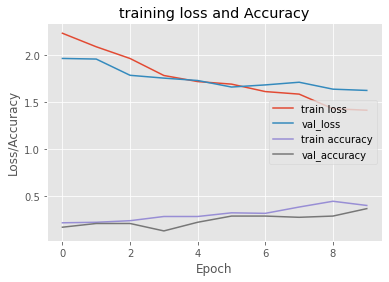

In [40]:
N= 100
plt.style.use("ggplot")
plt.figure()
plt.plot(r.history["loss"], label="train loss")
plt.plot( r.history["val_loss"], label="val_loss")
plt.plot(r.history["accuracy"], label="train accuracy")
plt.plot( r.history["val_accuracy"], label="val_accuracy")
plt.title("training loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("drive/My Drive/vgg19_model")

#  making prediction and classification report





In [41]:
y_predict = model.predict(valid_set)

In [42]:
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc
from PIL import Image
y_pred=model.predict_generator(generator=valid_set,)
y_pred=np.argmax(y_pred,axis=1)
print('classification report')
print(classification_report(valid_set.classes, y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


classification report
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        12
           1       0.36      0.50      0.42        16
           2       0.35      0.38      0.36        16
           3       0.08      0.22      0.12         9
           4       0.00      0.00      0.00        15
           5       0.40      0.25      0.31         8

    accuracy                           0.28        76
   macro avg       0.26      0.27      0.25        76
weighted avg       0.26      0.28      0.26        76



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
# This is formatted as code
```
plot confusion matrix 

Confusion Matrix without Normalization


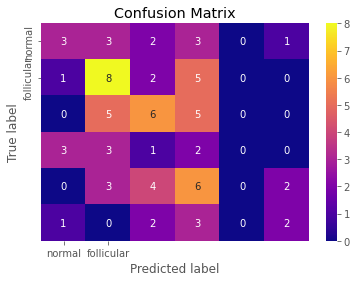

Confusion Matrix with Normalized Values


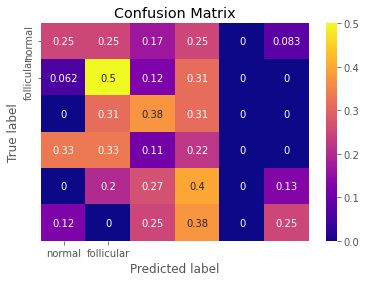

In [43]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
import seaborn as sns
def plot_confusion_matrix(normalize):
  classes = ['normal','follicular', 'intense', 'scar', 'trichiasis','corneal opacity']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(valid_set.classes, y_pred, normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')